# Classification of Apoptotic cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

In vivo identification of apoptotic and extracellular vesicle-bound live cells using image-based deep learning https://doi.org/10.1080%2F20013078.2020.1792683


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

data_path = "/pstore/data/DS4/Apoptotic_cell_detection/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 15311/15311 [00:02<00:00, 5553.56it/s]


...metadata prepration ended.
CPU times: user 248 ms, sys: 156 ms, total: 404 ms
Wall time: 3.28 s


In [6]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,822,labeled,apoptotic
1,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,12187,labeled,non-apoptotic
2,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2295,labeled,apoptotic
3,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,14306,labeled,non-apoptotic
4,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2584,labeled,apoptotic
...,...,...,...,...,...,...,...
15306,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,10365,labeled,apoptotic
15307,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,2952,labeled,apoptotic
15308,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,7308,labeled,non-apoptotic
15309,/pstore/data/DS4/Apoptotic_cell_detection/Expe...,Experiment_1,Donor_1,condition_1,3211,labeled,apoptotic


['apoptotic' 'non-apoptotic']


<AxesSubplot:>

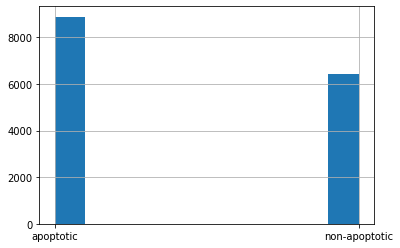

In [7]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [8]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

apoptotic
non-apoptotic


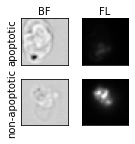

In [9]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 2)).reset_index(drop = True) ,  
                              figsize = (2,2),
                    channel_colors =  ["Greys", "Greys_r"],
                          channels = ["BF","FL"],
                    image_size = 32)



plt.savefig("Dataset 1 - apoptotic vs non apoptotic cells.png", bbox_inches='tight')
plt.savefig("Dataset 1 - apoptotic vs non apoptotic cells.svg", bbox_inches='tight')

In [10]:
set_of_interesting_classes = ["apoptotic" , 'non-apoptotic'] 
count_data = pd.DataFrame(columns = ["label", "count"])

for cl in set_of_interesting_classes:
    row_index = metadata.label == cl
    count_data = count_data.append({
        "label": cl,
        "count": row_index.sum()
    }, ignore_index = True)

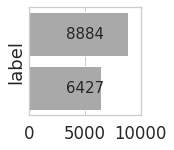

In [13]:
import seaborn as sns
sns.set(font_scale = 1.5)
sns.set_style("whitegrid")
figsize = (2,2)
fig, ax = plt.subplots(figsize=figsize)

ax = sns.barplot(data = count_data , y="label" , x="count", palette=['darkgray'], orient = "h", ax = ax)

for bar in ax.patches:

    ax.annotate(int(bar.get_width()) , 
                   (5000, 
                    bar.get_y() + bar.get_height() / 2), ha='center', va='center',
                   size=15, xytext=(0, 0),
                   textcoords='offset points')

ax.set_yticks([])
ax.set_xlabel("")
ax.set_xticks([0,5000,10000])

plt.savefig('count of labeled images.svg', bbox_inches="tight")